## EDA Visualizations for Image Recognition (Feature Map Activation)

## Dependencies and Imports

In [1]:
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import timm
import torch
import torchvision
from torchvision.models.feature_extraction import (create_feature_extractor,
                                                   get_graph_node_names)

%matplotlib inline
import glob
import os
import random
from math import ceil

from PIL import Image

plt.rcParams["figure.figsize"]= 16,8

import glob
from torchvision.models import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image

InteractiveShell.ast_node_interactivity = "all"

# importing modules
import urllib.request
from typing import *

from PIL import Image

### Import Custom Utils

Import utils function as script.

In [2]:
%cd ..
import utils

C:\Users\reighns\reighns_ml\reighns_ml_blog\docs\reighns_ml_journey\deep_learning\computer_vision\general\neural_network_interpretation


### Call Config from Utils

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
logger = utils.init_logger()

In [5]:
utils.seed_all()

Using Seed Number 1992


## Load Images

We load the images and plot the original image.

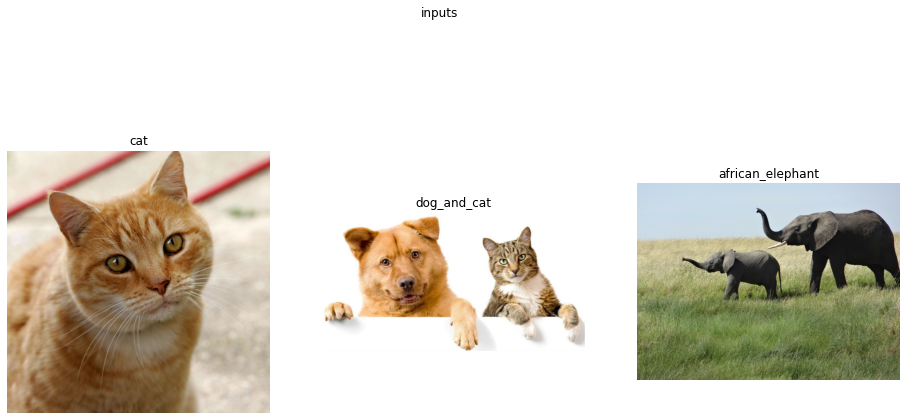

In [6]:
image_paths = glob.glob("./images/animals/*.*")
# elephant has RGBA idk why so need convert
images = list(map(lambda x: Image.open(x).convert("RGB"), image_paths))

utils.subplot(
    images,
    title="inputs",
    rows_titles=["cat", "dog_and_cat", "african_elephant"],
    nrows=1,
    ncols=3,
)

## Transforms Params (ImageNet)

In [7]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-
    """
    def __init__(self, mean, std):
        mean = torch.Tensor(mean)
        std = torch.Tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [8]:
imagenet_mean: List[float] = [0.485, 0.456, 0.406]
imagenet_std: List[float] = [0.229, 0.224, 0.225]
image_size: int = 224

normalized_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

inverse_normalized_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.ToTensor(),
        NormalizeInverse(mean=imagenet_mean, std=imagenet_std),
    ]
)

In [9]:
# We use torchvision's transform to transform the cat image with resize and normalization.
# Conveniently, also making it channel first!
cat_tensor = normalized_transform(images[0])
cat_and_dog_tensor = normalized_transform(images[1])

elephant_tensor = normalized_transform(images[2])
# assert cat_tensor.shape[0] == cat_and_dog_tensor.shape[0] == 3, "PyTorch expects Channel First!"


# Now feature_extractor expects batch_size x C x H x W, so we expand one dimension in the 0th dim
# and put them on device
cat_tensor = cat_tensor.unsqueeze(dim=0).to(device)
cat_and_dog_tensor = cat_and_dog_tensor.unsqueeze(dim=0).to(device)
elephant_tensor = elephant_tensor.unsqueeze(dim=0).to(device)

# logger.info(f"\n\ncat_tensor's shape:\n{cat_tensor.shape}\n\ndog_tensor's shape:\n{cat_and_dog_tensor.shape}")

In [10]:
images_dict: Dict[str, torch.Tensor] = {"cat": cat_tensor, "cat_and_dog": cat_and_dog_tensor, "elephant": elephant_tensor}

## Working with Torch Models

### Load the Models

In [12]:
alexnet_ = alexnet(pretrained=True).to(device)
vgg16_ = vgg16(pretrained=True).to(device)

### Torch Summary

In [11]:
import torchsummary

def torchsummary_wrapper(
    model, image_size: Tuple[int, int, int]
) -> torchsummary.model_statistics.ModelStatistics:
    """A torch wrapper to print out layers of a Model.

    Args:
        model (CustomNeuralNet): Model.
        image_size (Tuple[int, int, int]): Image size as a tuple of (channels, height, width).

    Returns:
        model_summary (torchsummary.model_statistics.ModelStatistics): Model summary.
    """

    model_summary = torchsummary.summary(model, image_size)
    return model_summary

In [13]:
alexnet_model_summary = torchsummary_wrapper(alexnet_, image_size = (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          23,296
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         307,392
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         663,936
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         884,992
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         590,080
|    └─ReLU: 2-12                        [-1, 256, 13, 13]   

In [14]:
vgg16_model_summary = torchsummary_wrapper(vgg16_, image_size = (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

### Forward Backward Hooks

In [15]:
def forward_hook(
    module_name: str, forward_activations: Dict[str, torch.Tensor]
) -> Callable:
    """In-place forward hook to save activations of a layer.

    Args:
        module_name (str): The name of the layer to hook.
        forward_activations (Dict[str, torch.Tensor]): The dictionary to save the activations.

    Returns:
        forward_hook_: The forward hook function.
    """

    def forward_hook_(module, input, output):
        # Save forward feature map activations
        forward_activations[module_name] = output.detach()

    return forward_hook_


def backward_hook(
    module_name: str, backward_gradients: Dict[str, torch.Tensor]
) -> Callable:
    """In-place backward hook to save gradients of a layer.

    Args:
        module_name (str): The name of the layer to hook.
        backward_gradients (Dict[str, torch.Tensor]): The dictionary to save the gradients.

    Returns:
        Callable: The backward hook function.
    """

    def backward_hook_(module, grad_input, grad_output):
        # Save the gradients correspond to the feature maps
        # This will only be saved when backwards is called.
        backward_gradients[module_name] = grad_output[0].detach()

    return backward_hook_

We define a function to get feature map activations.

In [16]:
def get_feature_maps_activations(
    model: Callable, image: torch.Tensor
) -> Union[List[Callable], Dict[str, torch.Tensor]]:
    """Get feature maps and activations from a model.

    Args:
        model (Callable): A model.
        image (torch.Tensor): The input image.

    Returns:
        handlers List[Callable]: A list of handlers.
        forward_activations Dict[str, torch.Tensor]: A dictionary of forward activations.
    """
    forward_activations = OrderedDict()

    handlers = []

    for name, module in model.named_modules():
        module_name = name + "_" + str(module)
        handlers.append(
            module.register_forward_hook(
                forward_hook(module_name, forward_activations)
            )
        )

    model = model.eval()

    y_logits = model(image)

    return handlers, forward_activations

In [17]:
_, alexnet_f = get_feature_maps_activations(alexnet_, image = images_dict["cat"])

In [18]:
_, vgg16_f = get_feature_maps_activations(vgg16_, image = images_dict["cat"])

### First Conv Layer Output Alexnet

We will get the first convolutional layer's output as follows. We note the following stats:

- There are 64 kernels.
    - Each kernel is of size 11 by 11. You can assume that each kernel is a 2d-image in grayscale.
- Therefore, the first conv layer output is also a stack of 64 2d-image, output by the 64 kernels respectively. 
    - We traditionally call them **feature maps**.
    - Each 2d output is of 55 by 55 shape. You can assume that this is a 2d-image with dimensions 55 by 55. Note you can calculate by hand that 55 by 55 is correct.
    - We can squeeze the first dimension as this is not needed since we are dealing with 1 image.

In [19]:
first_conv_layer_output = alexnet_f["features.0_Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))"]

print(first_conv_layer_output.shape)

first_conv_layer_output = first_conv_layer_output.squeeze(dim=0)

print(first_conv_layer_output.shape)

torch.Size([1, 64, 55, 55])
torch.Size([64, 55, 55])


For plotting, we will use the [repo](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-)'s code verbatim.

Note we set number of columns and rows to be 8 by 8 to see all 64 feature maps.

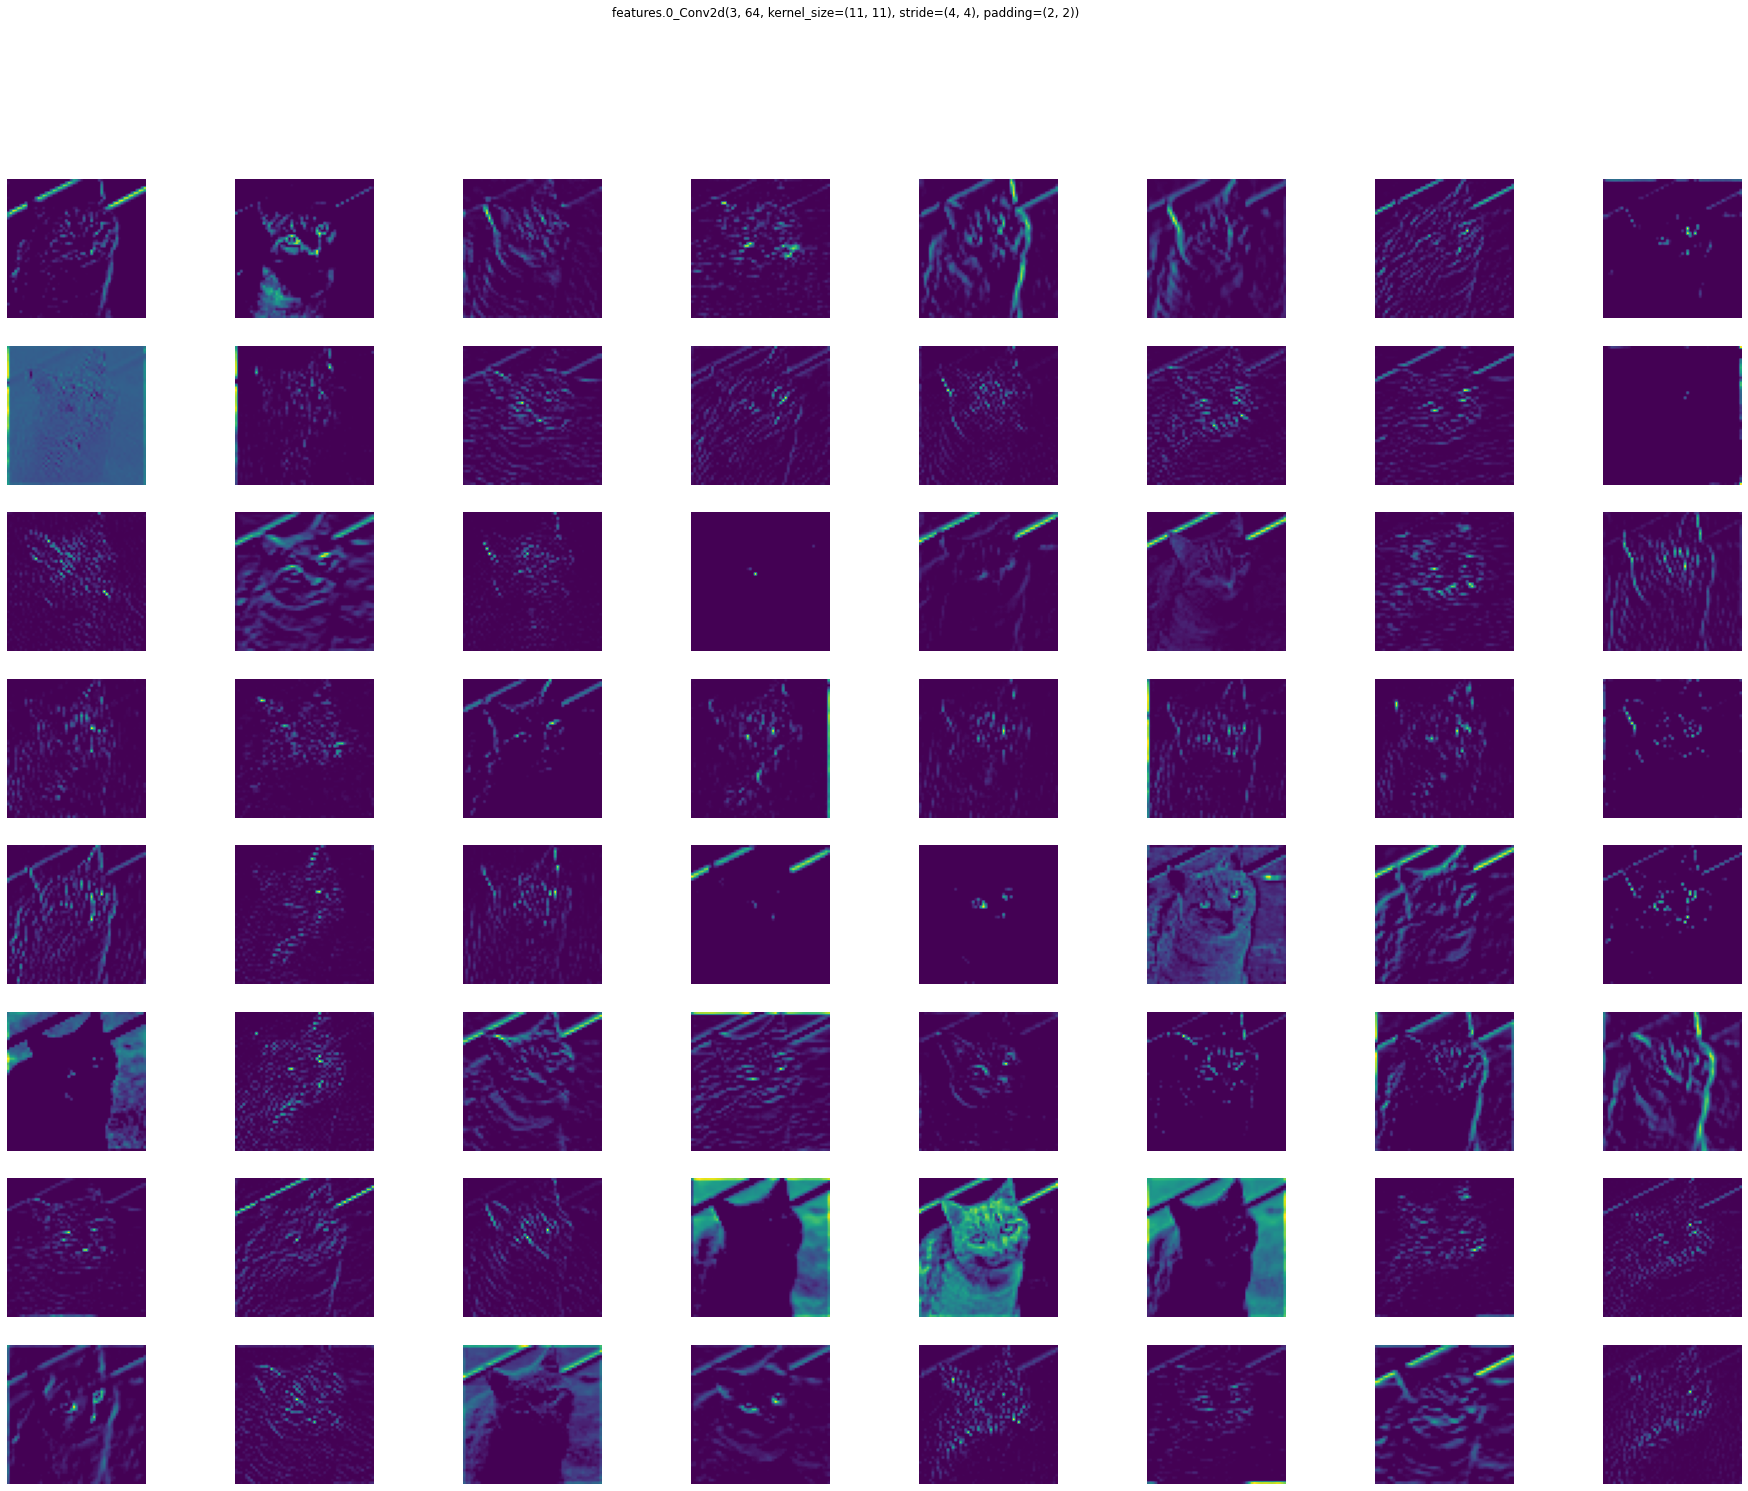

In [20]:
plt.rcParams["figure.figsize"]= 32, 24
utils.subplot(first_conv_layer_output, utils.tensor2img, title="features.0_Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))", ncols=8, nrows=8)

In [21]:
# plt.rcParams["figure.figsize"]= 32, 24
# utils.subplot(f["features.2_MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)"][0], utils.tensor2img, title="eatures.2_MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)", ncols=8, nrows=8)

### First Conv Layer Output VGG16

In [22]:
first_conv_layer_output = vgg16_f["features.0_Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))"]

print(first_conv_layer_output.shape)

first_conv_layer_output = first_conv_layer_output.squeeze(dim=0)

print(first_conv_layer_output.shape)

torch.Size([1, 64, 224, 224])
torch.Size([64, 224, 224])


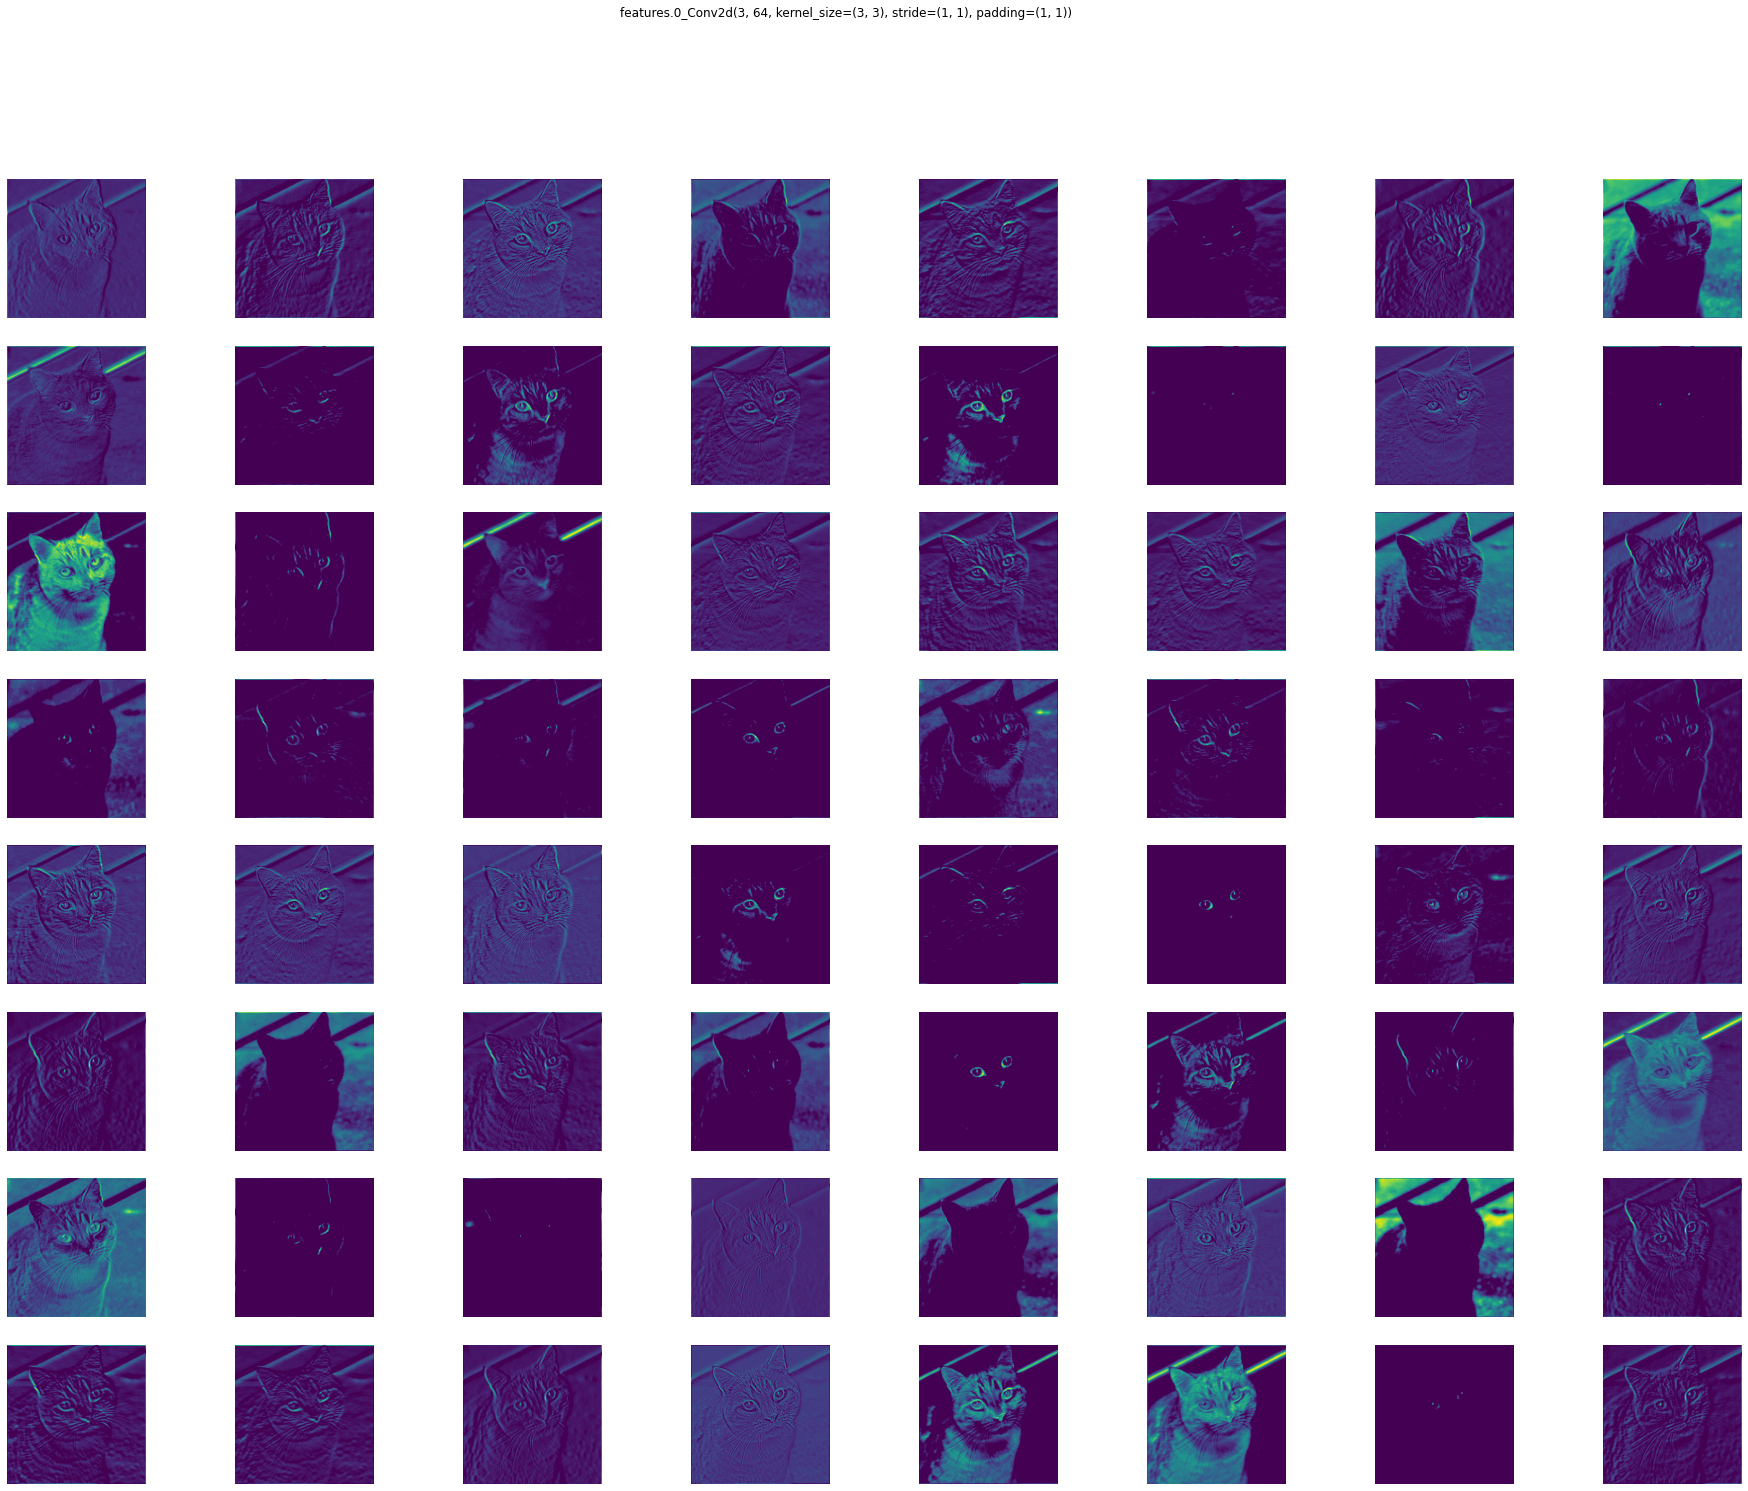

In [23]:
plt.rcParams["figure.figsize"]= 32, 24
utils.subplot(first_conv_layer_output, utils.tensor2img, title="features.0_Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))", ncols=8, nrows=8)

## Mean and Sum Reduce of the Feature Maps

In the above section, if there are 64 feature maps after a conv layer, we will plot all 64 feauture maps.

In the next section, we can either sum or average all 64 feature maps to **reduce** them to 1 single feature map. 